In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from dataclasses import dataclass

# set font to avenir next
plt.rcParams['font.family'] = 'Avenir'
# set plot to 300dpi
plt.rcParams['figure.dpi'] = 300

In [152]:
@dataclass
class ArduinoData:
    biggest_slope: float
    time_of_biggest_slope: float
    KI: float
    Distance: float

def get_max_slope(filepath, plot=False, window_size=35):
    df = pd.DataFrame(columns=["time", "value", "slope_read", "slope_calc"])

    starting_time = None

    value_avg_buffer = [0] * window_size
    slope_avg_buffer = [0] * window_size
    time_buffer = [0] * window_size
    value_avg_running = 0
    index = 0

    with open(filepath, "r") as f:
        for i, line in enumerate(f):
            if i == 0:
                continue

            if line.startswith("Stopped"):
                continue
            if line.startswith("Biggest Slope"):
                biggest_slope = float(line.split(":")[1])
                continue
            if line.startswith("Time of Biggest Slope"):
                time_of_biggest_slope = float(line.split(":")[1])
                continue
            if line.startswith("KI"):
                KI = float(line.split(":")[1])
                continue
            if line.startswith("Distance"):
                Distance = float(line.split(":")[1])
                continue
            
            try:
                time, value, slope = line.split(",")
                time = float(time)
                value = float(value)
                slope_read = float(slope)
            except:
                continue

            if i < window_size:
                value_avg_running += (value - value_avg_running) / i
                slope_avg_buffer[i] = slope_read
                value_avg_buffer[i] = value_avg_running
                time_buffer[i] = time
                continue

            value_avg_running += (value - value_avg_buffer[index]) / window_size
            slope_calc = (value_avg_running - value_avg_buffer[index]) / (time - time_buffer[index])
            value_avg_buffer[index] = value_avg_running
            time_buffer[index] = time
            index = (index + 1) % window_size

            df.loc[i] = [time, value, slope_read, slope_calc]

    starting_time = df["time"].iloc[0]
    df["time"] = df["time"] - starting_time

    max_slope = df[df["time"] > 4]["slope_calc"].max()
    time_of_max = df[df["slope_calc"] == max_slope]["time"].values[0]

    if plot:
        fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(5, 3))
        fig.subplots_adjust(hspace=0.3)
        ax1.plot(df["time"], df["value"], color="blue")
        ax2.plot(df["time"], df["slope_calc"], color="red")
        plt.xlim(0, 35)
        plt.xlabel("Time (s)")
        ax1.set_ylabel("Measured Value")
        ax2.set_ylabel("Running Derivative")
        plt.title("Relative Absorbance Over Time", loc="center", pad=100)
        ax1.axvline(x=9.4, color="black", linestyle="--", linewidth=1)
        ax2.axvline(x=9.4, color="black", linestyle="--", linewidth=1)
        # thinner line weight
        ax1.axvline(x=time_of_max + 0.05, color="black", linestyle="--", linewidth=1)
        ax2.axvline(x=time_of_max + 0.05, color="black", linestyle="--", linewidth=1)
        plt.show()

    return time_of_max

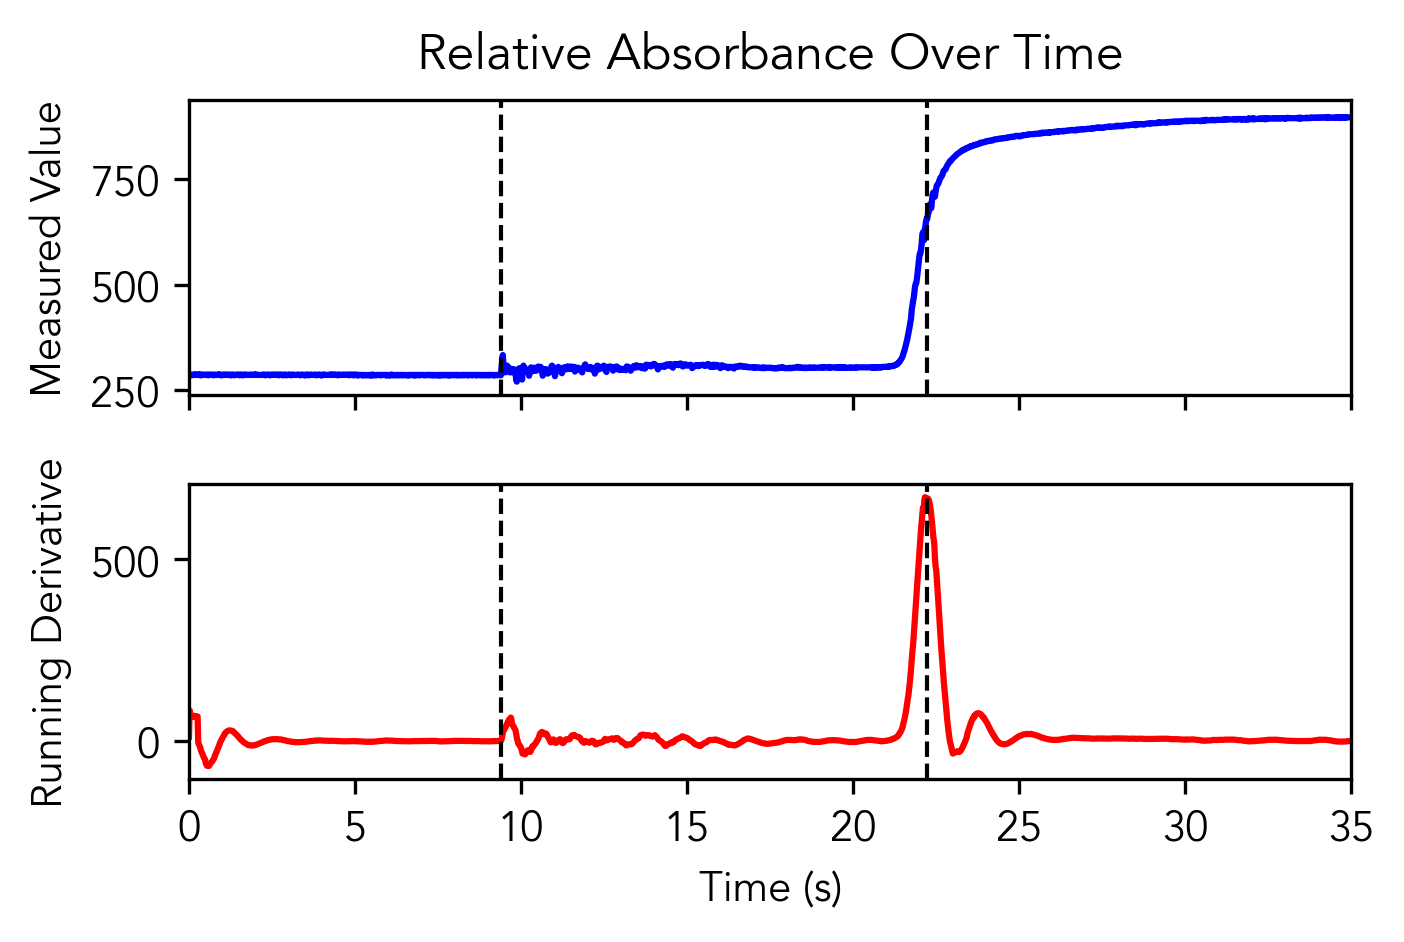

22.160000000000004


In [153]:
path = "../data/plot/example2.csv"
print(get_max_slope(path, plot=True, window_size=15))

<function matplotlib.pyplot.clf() -> 'None'>

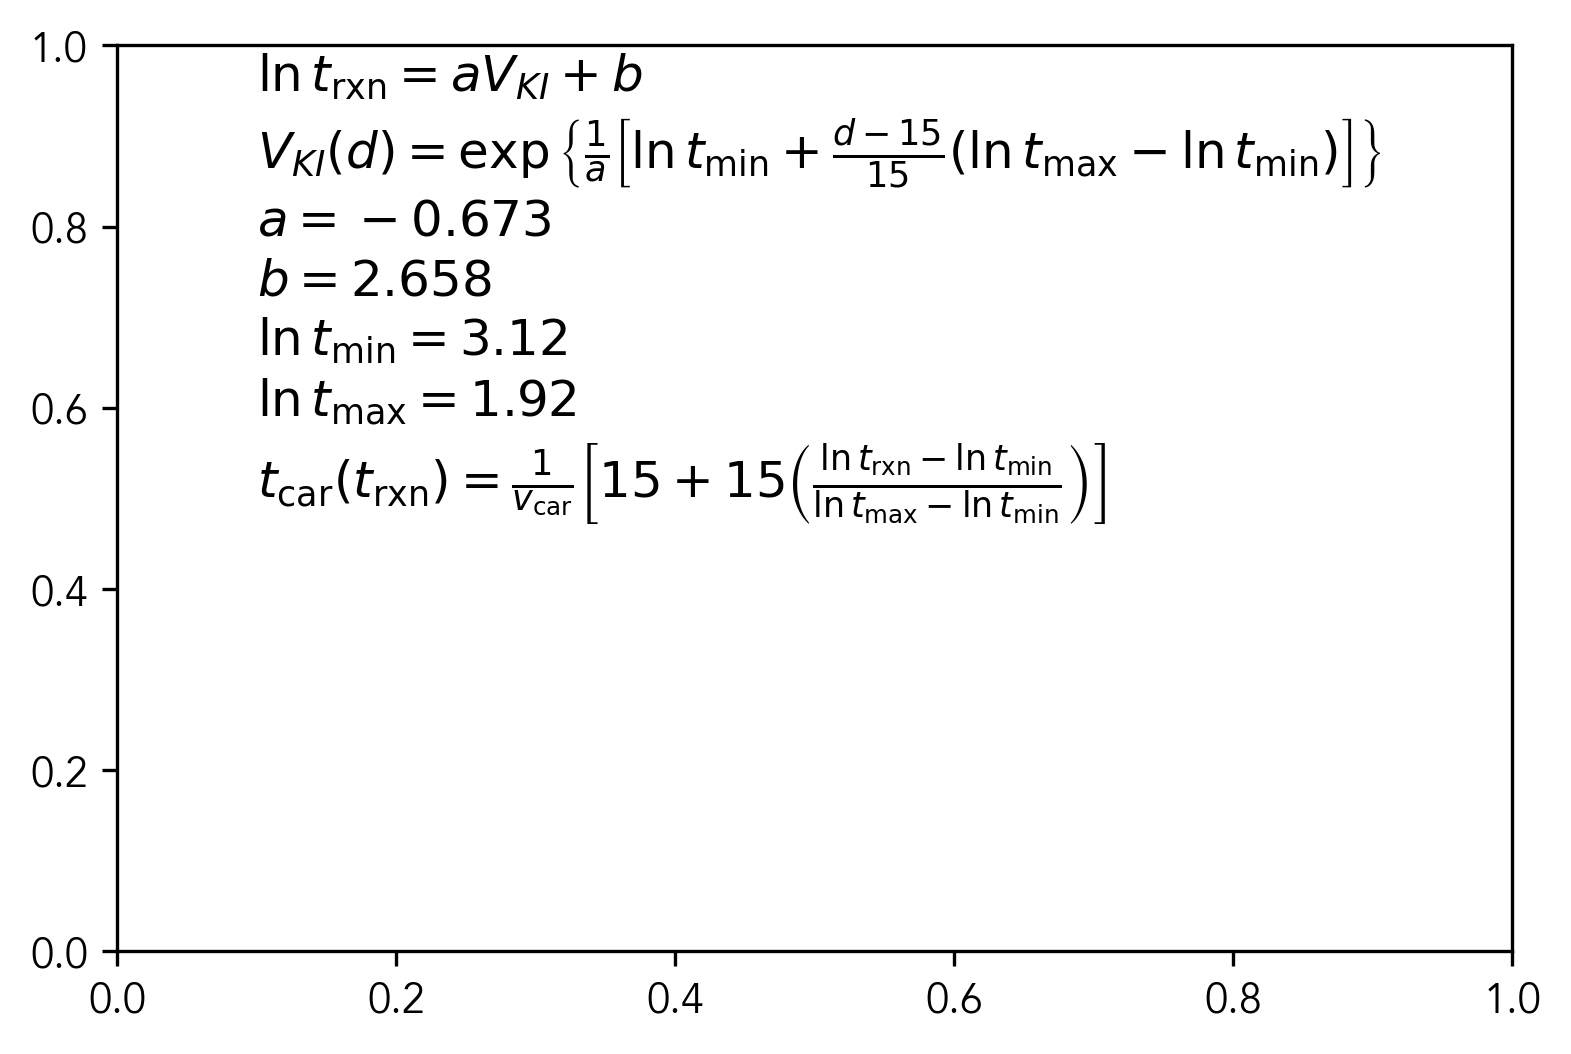

In [179]:
# matplotlib print latex
#a: -0.6730703990589936 b: 2.6584374135870856
eq1 = r'$\ln t_\text{rxn} = a V_{KI} + b$'
eq2 = r'$V_{KI}(d) = \exp \left\{ \frac{1}{a} \left[ \ln t_\text{min} + \frac{d - 15}{15} \left( \ln t_\text{max} - \ln t_\text{min} \right) \right] \right\}$'
eq3 = r'$a = -0.673$'
eq4 = r'$b = 2.658$'
eq5 = r'$\ln t_\text{min} = 3.12$'
eq6 = r'$\ln t_\text{max} = 1.92$'
eq7 = r'$t_\text{car}(t_\text{rxn}) = \frac{1}{v_\text{car}} \left[ 15 + 15 \left( \frac{\ln t_\text{rxn} - \ln t_\text{min}}{\ln t_\text{max} - \ln t_\text{min}} \right) \right]$'
combined = eq1 + "\n" + eq2 + "\n" + eq3 + "\n" + eq4 + "\n" + eq5 + "\n" + eq6 + "\n" + eq7
plt.annotate(combined, xy=(0.1, 0.5), xycoords='axes fraction', fontsize=12)
plt.clf

       time  value  slope
0      0.00    286   0.03
1      0.00    287  -0.01
2      0.00    287  -0.01
3      0.00    287   0.04
4      0.02    287   0.04
...     ...    ...    ...
3128  60.45    905   0.49
3129  60.47    906   0.55
3130  60.49    906   0.57
3131  60.51    906   0.56
3132  60.52    906    NaN

[3133 rows x 3 columns]


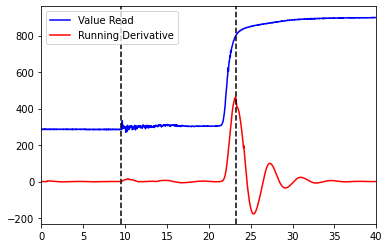

In [34]:
# set dpi to 
plot_df = pd.read_csv("../data/plot/example2.csv")
plot_df["time"] = plot_df["time"] - plot_df["time"].iloc[0]
print(plot_df)
plt.plot(plot_df["time"], plot_df["value"], label="Value Read", color="blue")
plt.plot(plot_df["time"], plot_df["slope"], label="Running Derivative", color="red")
plt.xlim(min(plot_df["time"]), 40)
# add vertical line at 9.5 seconds
plt.axvline(x=9.5, color="black", linestyle="--")
plt.axvline(x=plot_df[plot_df["slope"] == plot_df["slope"].max()]["time"].values[0], color="black", linestyle="--")
plt.legend()
plt.show()

In [167]:
def get_time_data(directory):
    df = pd.DataFrame(columns=["Date", "KI", "time", "filename"])
    for filename in os.listdir(directory):
        ki = filename.split("mL")[0]
        filepath = os.path.join(directory, filename)
        time_of_max = get_max_slope(filepath, plot=False, window_size=35)
        date = filename.split(" ")[1].split(".")[0]
        df.loc[len(df)] = [date, float(ki), float(time_of_max), filename]
    
    df["date"] = pd.to_datetime(df["Date"])
    df["ln KI"] = np.log(df["KI"])
    df["ln time"] = np.log(df["time"])
    return df

In [165]:
data_dir = "../data/1.5M_SA new"

df = get_time_data(data_dir)

df = df[df["KI"] >= 0.75]
df = df[df["KI"] <= 3]

a, b = np.polyfit(df["ln KI"], df["ln time"], 1)
r2 = np.corrcoef(df["ln KI"], df["ln time"])[0, 1] ** 2

for date in df["date"].unique():
    if date != pd.to_datetime("10-24-2024"):
        continue
    print(date)
    plt.scatter(df[df["date"] == date]["ln KI"], df[df["date"] == date]["ln time"], label=date)
    # get mean residuals
    residuals = df[df["date"] == date]["ln time"] - (a * df[df["date"] == date]["ln KI"] + b)
    mean_residuals = residuals.mean()
    plt.plot(df["ln KI"], a * df["ln KI"] + b, color="red")
    plt.plot(df["ln KI"], a * df["ln KI"] + b + mean_residuals, color="green")
    plt.xlabel("ln KI")
    plt.ylabel("ln time")
    #plt.show()
    plt.clf()

    x = np.exp(-b/a)
    y = 1/a
    t_plot = np.linspace(5, 18, 100)
    m_plot = x * t_plot ** y

    plt.scatter(df[df["date"] == date]["KI"], df[df["date"] == date]["time"], label=date)
    plt.plot(m_plot, t_plot, color="red")

    x = np.exp(-(b + mean_residuals)/a)
    m_plot = x * t_plot ** y
    plt.plot(m_plot, t_plot, color="green")
    plt.xlim(0.75, 3.25)
    plt.xlabel("KI")
    plt.ylabel("time")
    #plt.show()
    plt.clf()

#print(df[df["date"] == pd.to_datetime("10-24-2024")])

# drop rows with date 2024-10-22
df = df[df["date"] != pd.to_datetime("10-22-2024")]
#df = df[df["date"] != pd.to_datetime("10-21-2024")]
#df = df[df["date"] != pd.to_datetime("10-07-2024")]


2024-10-24 00:00:00


/var/folders/99/7768vz3j71v4j9_0ywr2cl540000gn/T/ipykernel_37955/1937962095.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["date"] = pd.to_datetime(df["Date"])


<Figure size 1800x1200 with 0 Axes>

og
a = -0.727757690014426
b = 2.691287201310679
lntmin = 2.90065004181675
lntmax = 1.8917636598881136


/var/folders/99/7768vz3j71v4j9_0ywr2cl540000gn/T/ipykernel_37955/3185854939.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["date"] = pd.to_datetime(df["Date"])


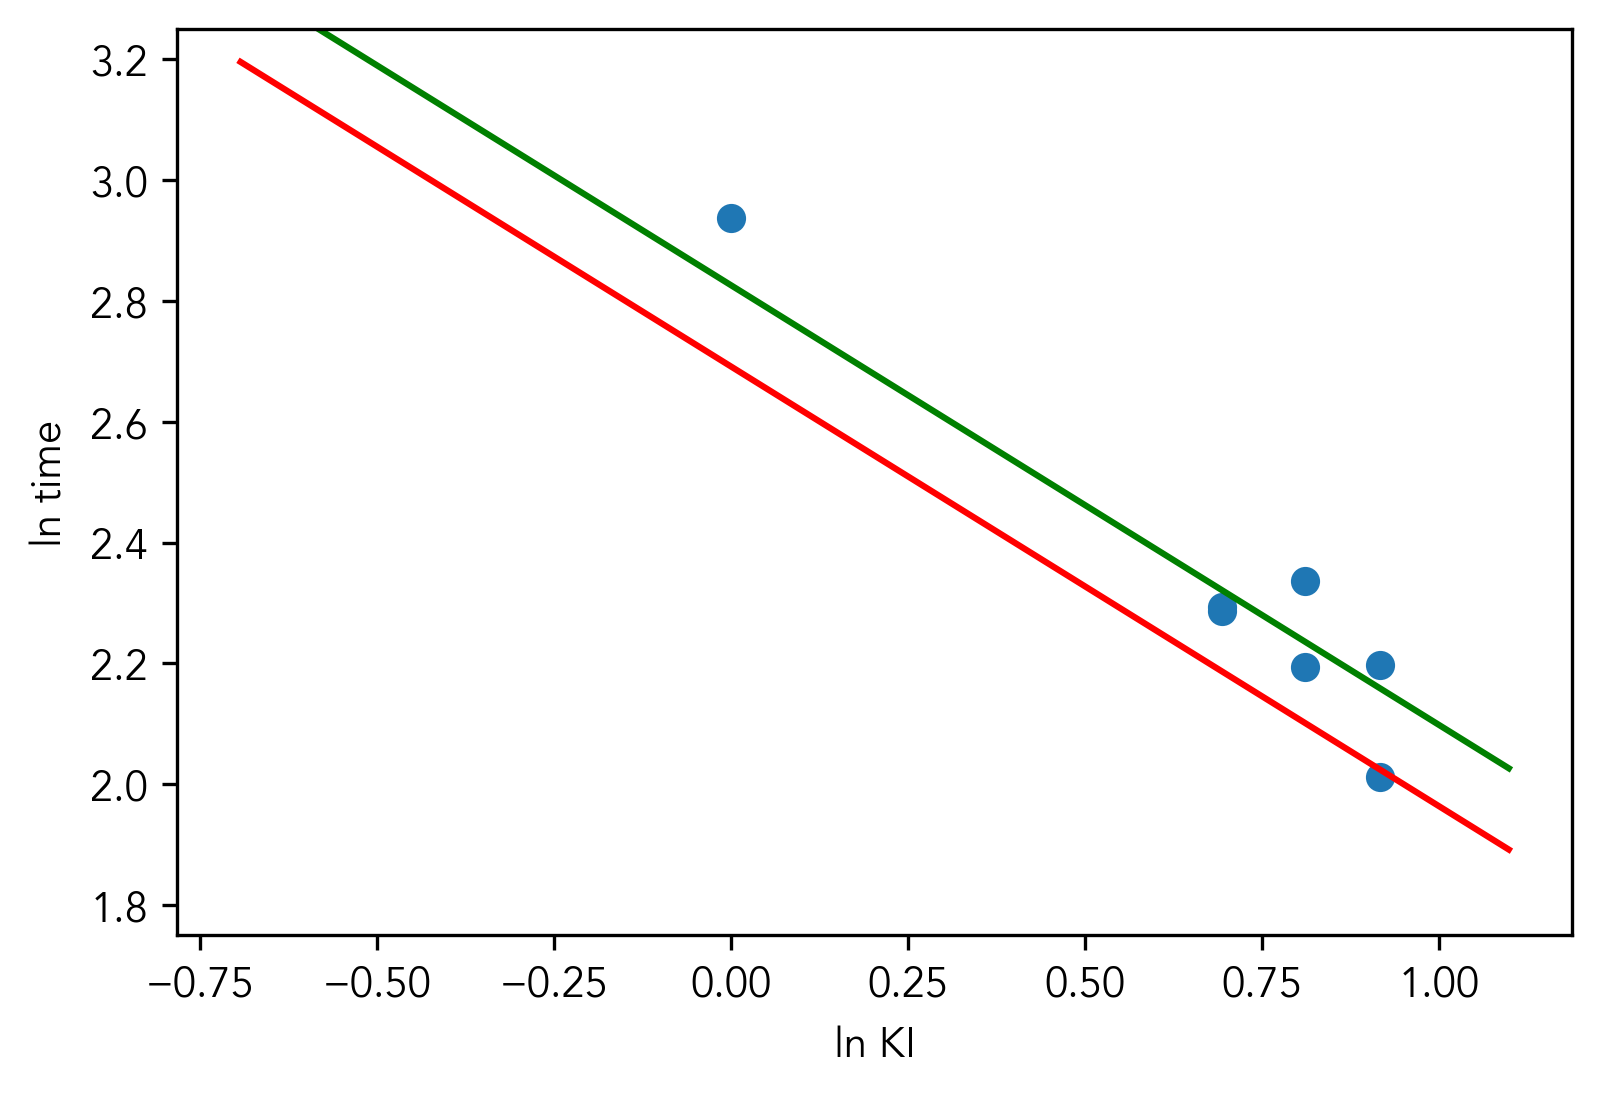

new
a = -0.727757690014426
b = 2.825826574353365
lntmin = 3.035189414859436
lntmax = 2.0263030329308


In [200]:
a = -0.727757690014426
b = 2.691287201310679
Vmin = 0.75
Vmax = 3
lntmin = a * np.log(Vmin) + b
lntmax = a * np.log(Vmax) + b
print("og")
print(f"a = {a}")
print(f"b = {b}")
print(f"lntmin = {lntmin}")
print(f"lntmax = {lntmax}")

df = get_time_data("../data/nationals/")

plt.scatter(df["ln KI"], df["ln time"])

xrange = np.linspace(np.log(0.5), np.log(3), 100)
plt.plot(xrange, a * xrange + b, color="red")
plt.xlabel("ln KI")
plt.ylabel("ln time")
plt.ylim(1.75, 3.25)

residuals = df["ln time"] - (a * df["ln KI"] + b)
mean_residuals = residuals.mean()
plt.plot(xrange, a * xrange + b + mean_residuals, color="green")
plt.show()

print("new")
b_new = b + mean_residuals
print(f"a = {a}")
print(f"b = {b_new}")
print(f"lntmin = {a * np.log(Vmin) + b_new}")
print(f"lntmax = {a * np.log(Vmax) + b_new}")


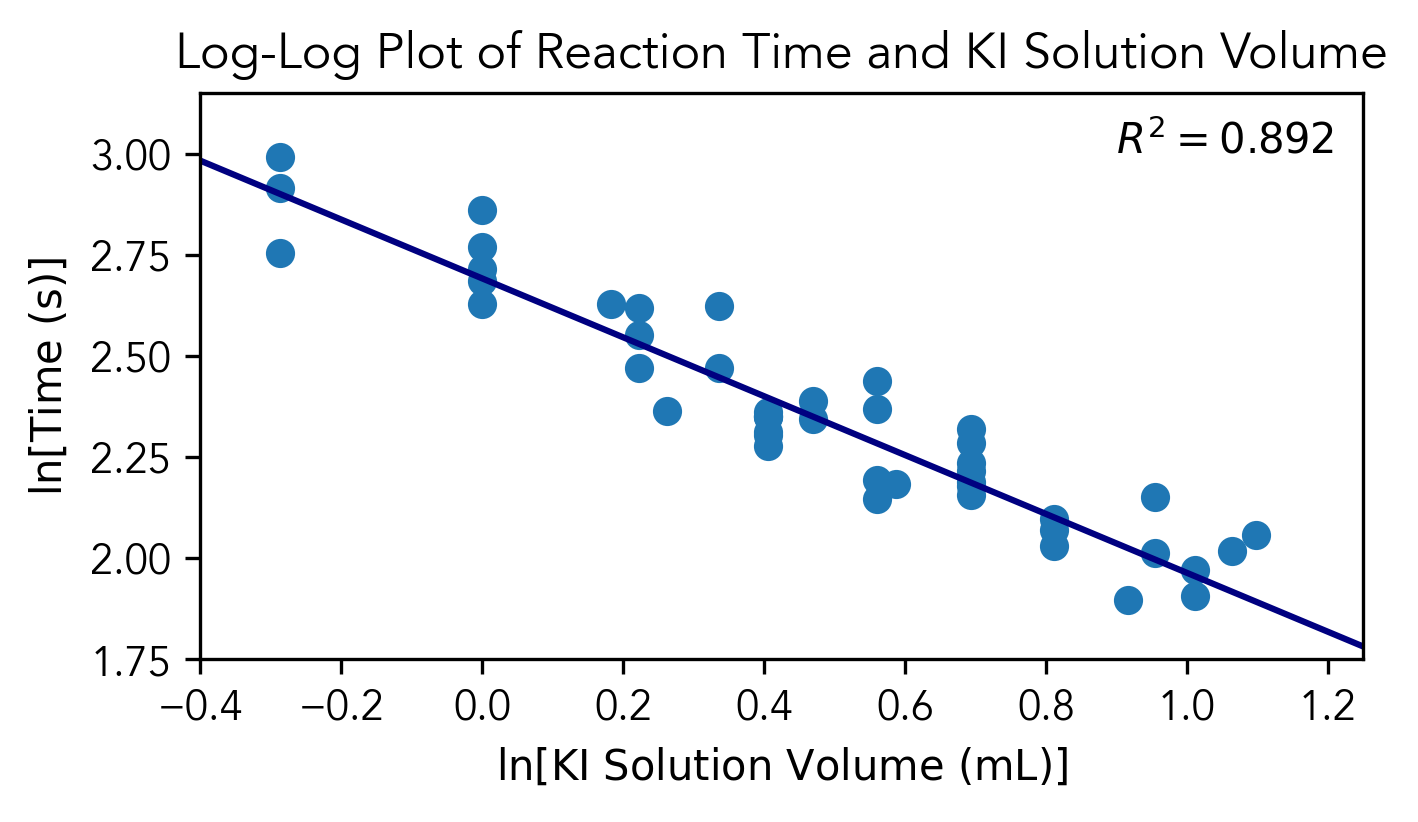

a: -0.727757690014426 b: 2.691287201310679


<Figure size 1800x1200 with 0 Axes>

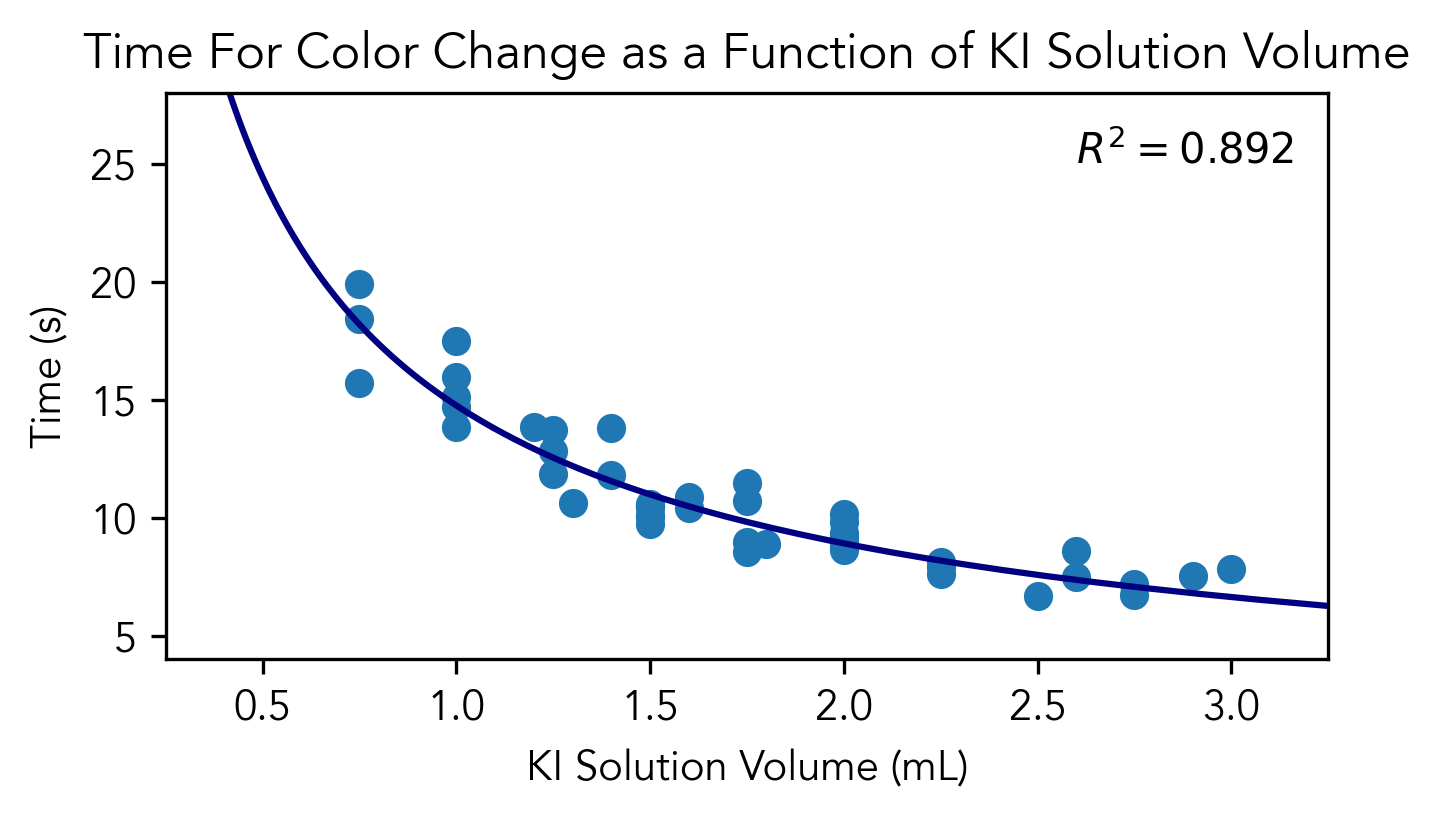

x: 40.36866848453623 y: -1.3740837283082195


In [164]:
plt.figure(figsize=(5, 2.5))
lnvki_plot = np.linspace(-1, 1.5, 100)
lnt_plot = a * lnvki_plot + b
plt.plot(lnvki_plot, lnt_plot, color="navy")
plt.scatter(df["ln KI"], df["ln time"])
plt.xlabel(r"$\ln [\text{KI Solution Volume (mL)}]$")
plt.ylabel(r"$\ln [\text{Time (s)}]$")
plt.xlim(-0.4, 1.25)
plt.ylim(1.75, 3.15)
plt.title("Log-Log Plot of Reaction Time and KI Solution Volume")
plt.text(0.9, 3, r"$R^2 = " + f"{r2:.3f}" + r"$", fontsize=10)
plt.show()
plt.clf()
print("a:", a, "b:", b)

x = np.exp(-b/a)
y = 1/a
t_plot = np.linspace(5, 30, 100)
m_plot = x * t_plot ** y

plt.figure(figsize=(5, 2.5))
plt.plot(m_plot, t_plot, color="navy")
plt.scatter(df["KI"], df["time"])
plt.xlim(0.25, 3.25)
plt.ylim(4, 28)
plt.title("Time For Color Change as a Function of KI Solution Volume")
plt.xlabel("KI Solution Volume (mL)")
plt.ylabel("Time (s)")
plt.text(2.6, 25, r"$R^2 = " + f"{r2:.3f}" + r"$", fontsize=10)
plt.show()
print("x:", x, "y:", y)

In [97]:
print(a*np.log(3)+b)

1.9189940020421268


In [223]:
a = -0.727757690014426
b = 2.825826574353365
lntmin = 3.035189414859436
lntmax = 2.0263030329308

a = -0.727757690014426
b = 2.691287201310679
lntmin = 2.90065004181675
lntmax = 1.8917636598881136

d = 26.62
print(np.exp((1/a) * (lntmin + (d-15)/15*(lntmax-lntmin) - b)))


2.195113951484878
